<a href="https://colab.research.google.com/github/LeninGF/CoursesNotes/blob/main/InteligenciaArtificalGenerativa/Problems/inception/inception2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inception Module

- Coder: Lenin G. Falconí
- Date: 2024-10-28
- Class: IA-Generativa

## Instrucciones:

- Añadir más módulos Inception y probar con una red más compleja
- Aumentar el número de filtros en cada convolución para captar más detalles.
- Usar Dropout y Batch Normalization para evitar el sobreajuste
- Cambiar hiperparámetros: Ajustar el batch size, epochs y probar diferentes
optimizadores.
- Incluir Data Augmentation. Aplicar transformaciones a las imágenes de
entrenamiento para mejorar la generalización.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, Dense, Flatten, GlobalAvgPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
# Definir el bloque Inception
def inception_module(input_tensor, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(input_tensor)

    # 3x3 convolution branch
    conv_3x3_reduce = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3_reduce)

    # 5x5 convolution branch
    conv_5x5_reduce = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5_reduce)

    # Max pooling branch
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate all branches
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)

    return output

In [4]:
# Cargar CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalización de los datos

y_train = to_categorical(y_train, 10)  # One-hot encoding de las etiquetas
y_test = to_categorical(y_test, 10)

In [5]:
# Definir la arquitectura del modelo con un bloque Inception
input_tensor = Input(shape=(32, 32, 3))
x = inception_module(input_tensor, 32, 32, 64, 16, 32, 32)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

In [6]:
# Crear y compilar el modelo
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar la estructura del modelo (resumen)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 16)     │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │         12,832 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 32)     │            128 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 160)    │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 163840)         │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     20,971,648 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10)             │          1,290 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,004,714 (80.13 MB)

 Trainable params: 21,004,714 (80.13 MB)

 Non-trainable params: 0 (0.00 B)

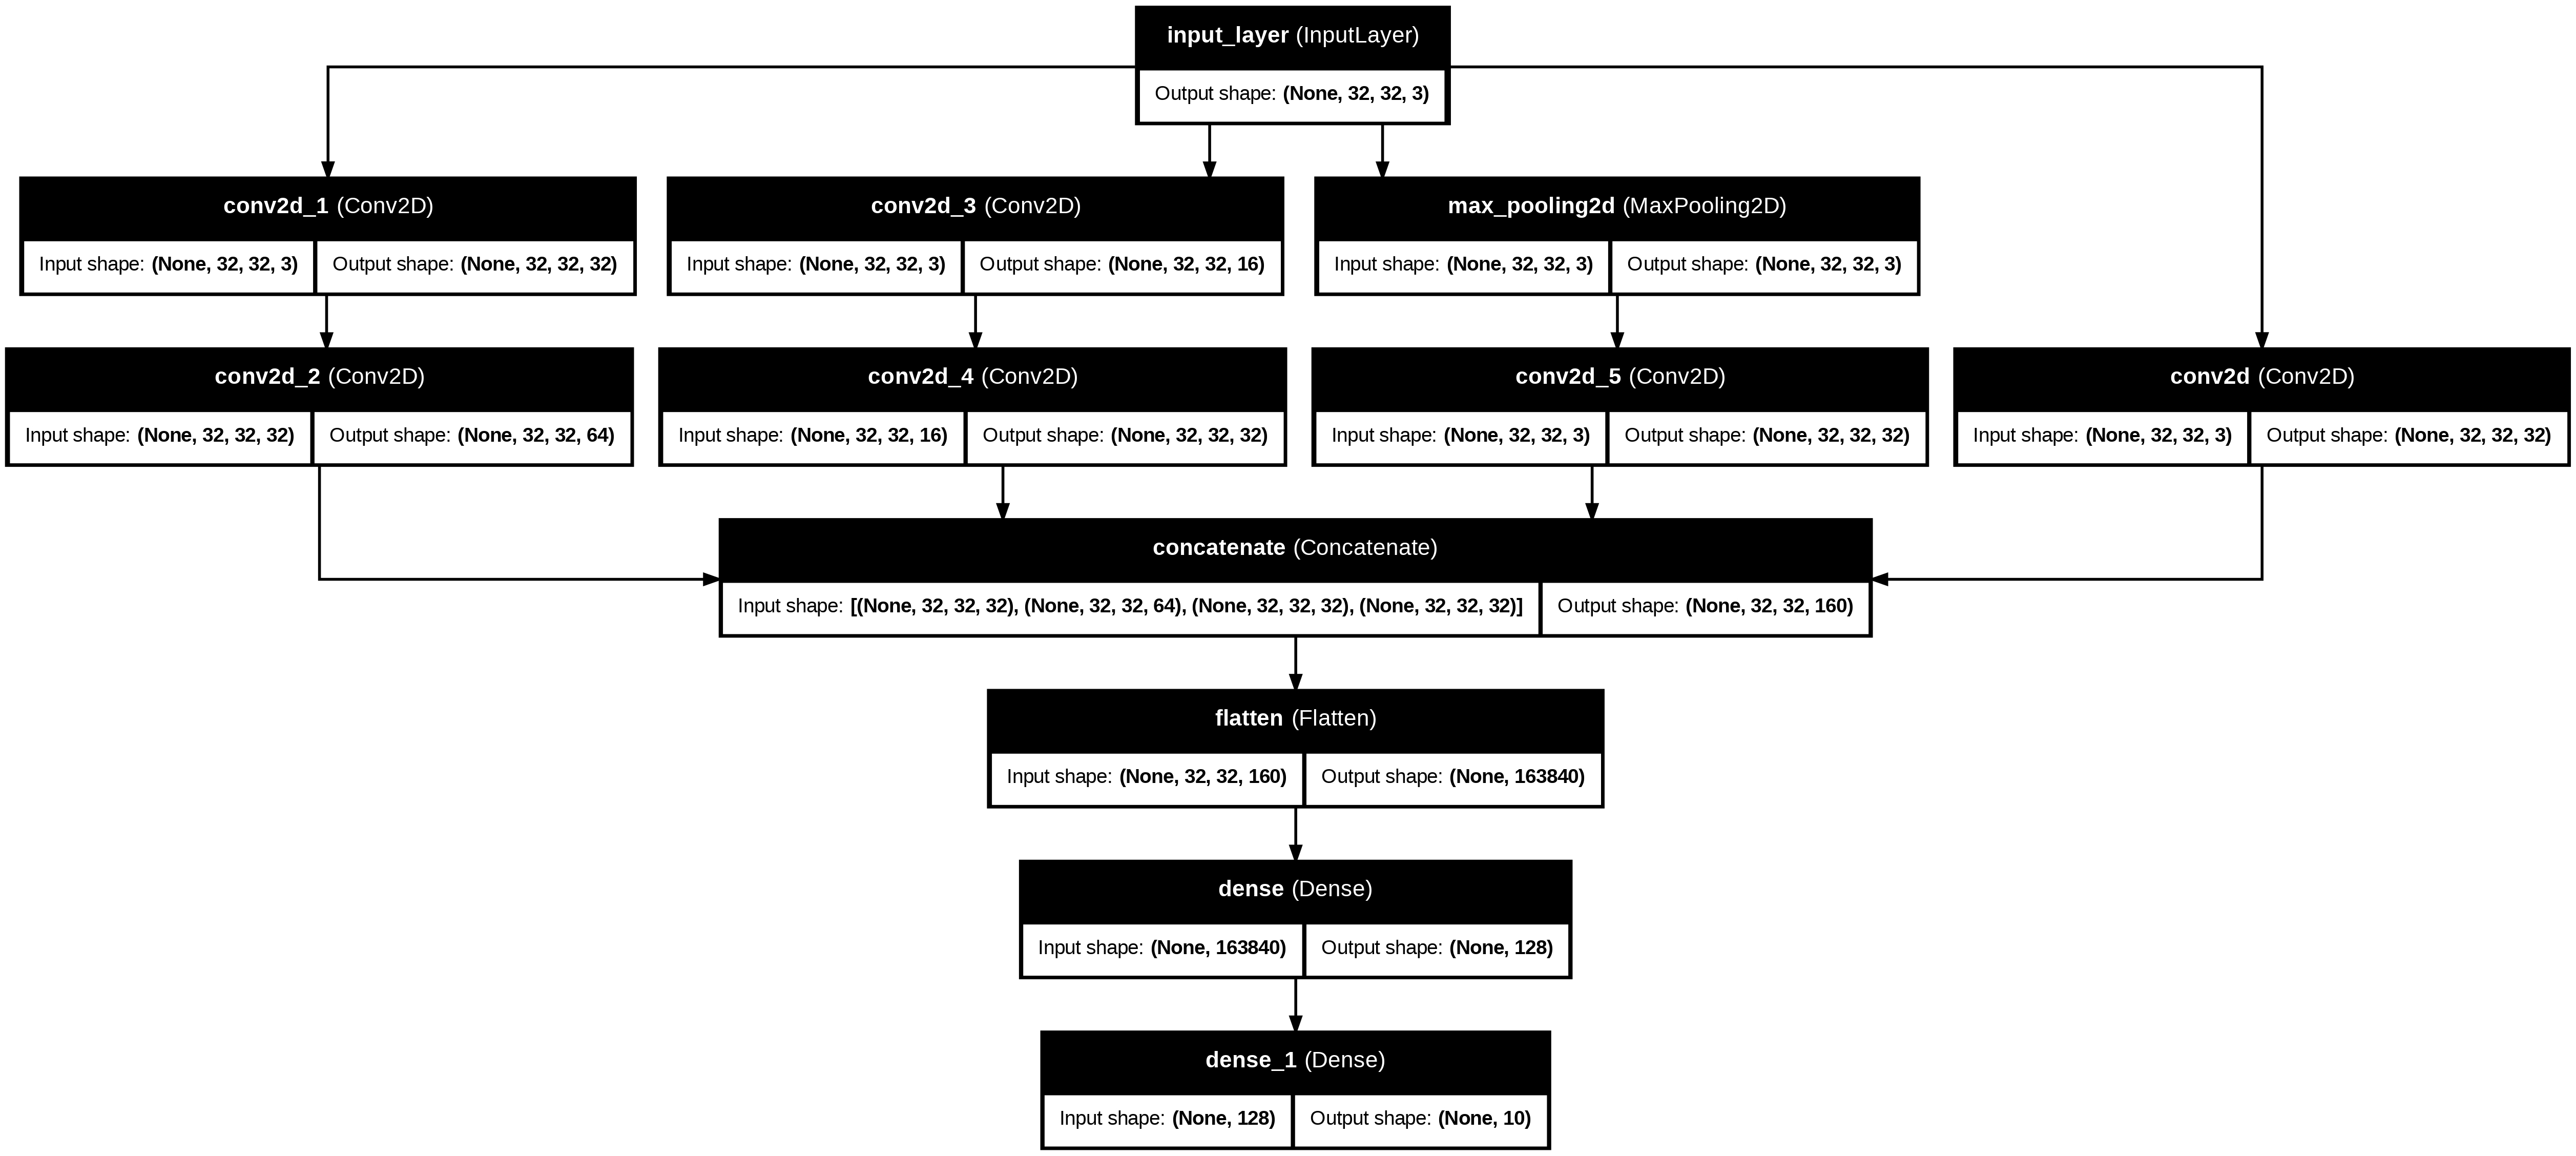

In [7]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
plot_model(model, to_file='model_architectureM1.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_architectureM1.png'))

In [8]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.2494 - loss: 2.4869 - val_accuracy: 0.4574 - val_loss: 1.4712
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4895 - loss: 1.4044 - val_accuracy: 0.5351 - val_loss: 1.2811
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5554 - loss: 1.2253 - val_accuracy: 0.5432 - val_loss: 1.2503
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6098 - loss: 1.0760 - val_accuracy: 0.5702 - val_loss: 1.2107
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6520 - loss: 0.9663 - val_accuracy: 0.5961 - val_loss: 1.1664
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6972 - loss: 0.8488 - val_accuracy: 0.6089 - val_loss: 1.1572
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7383 - loss: 0.7348 - val_accuracy: 0.5940 - val_loss: 1.2722
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7826 - loss: 0.6197 - 

In [9]:
# Evaluar el modelo en el conjunto de pruebas
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

313/313 - 2s - 5ms/step - accuracy: 0.6048 - loss: 1.5656
Test accuracy: 0.6048


In [10]:
# Función para mostrar imágenes y predicciones
def plot_images_with_predictions(images, labels, predictions, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Mostrar 9 imágenes
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[np.argmax(labels[i])]}\nPred: {class_names[np.argmax(predictions[i])]}")
        plt.axis('off')
    plt.show()

In [11]:
# Nombres de las clases en CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
# Hacer predicciones sobre algunas imágenes de prueba
num_images_to_display = 9
predictions = model.predict(x_test[:num_images_to_display])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


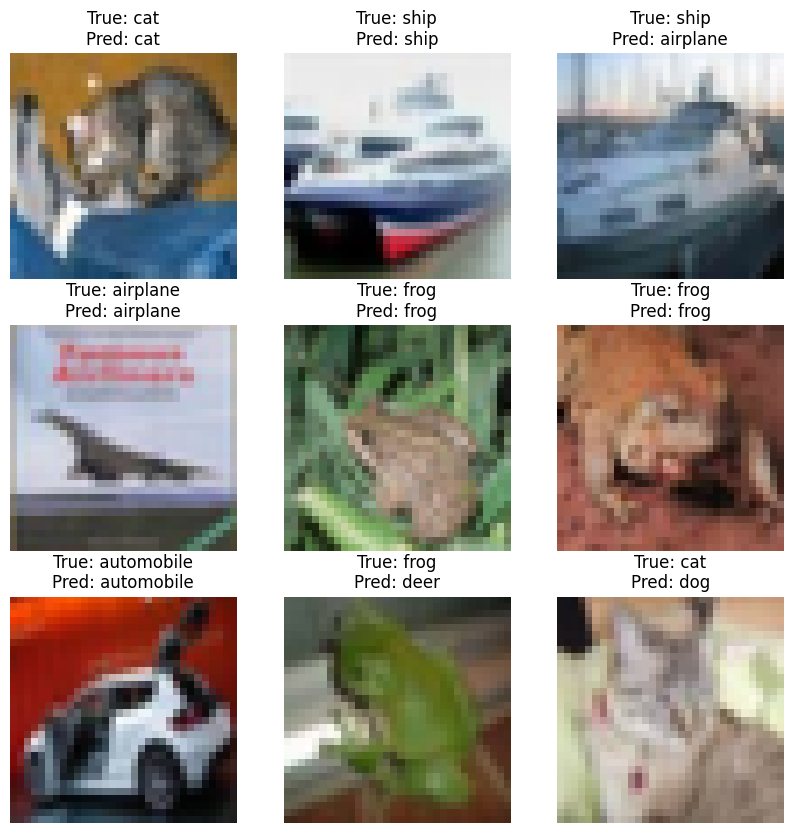

In [13]:
# Mostrar imágenes con predicciones
plot_images_with_predictions(x_test[:num_images_to_display], y_test[:num_images_to_display], predictions, class_names)

## Solution

Generando el aumento de datos en la primera capa

In [14]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [15]:
input_tensor = Input(shape=(32, 32, 3))
# Apply data augmentation
x = data_augmentation(input_tensor)
x = inception_module(x, 32,32,64,16,32,32)
x = inception_module(x, 64,64,128,16,64,64)
x = inception_module(x, 64,128,128,32,128,128)
x = BatchNormalization()(x)
x = GlobalAvgPool2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
y = Dense(10, activation='softmax')(x)

In [22]:
# Crear y compilar el modelo
model2 = Model(input_tensor, y)
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar la estructura del modelo (resumen)
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 32, 32, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 32)     │            128 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 16)     │             64 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 3)      │              0 │ sequential[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 32)     │            128 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 32)     │         12,832 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 32)     │            128 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 160)    │              0 │ conv2d_6[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_8[0][0],        │
│                           │                        │                │ conv2d_10[0][0],       │
│                           │                        │                │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 32, 64)     │         10,304 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 32, 32, 16)     │          2,576 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 160)    │              0 │ concatenate_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 64)     │         10,304 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 32, 32, 64)     │         25,664 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)   

 Total params: 647,194 (2.47 MB)

 Trainable params: 646,298 (2.47 MB)

 Non-trainable params: 896 (3.50 KB)

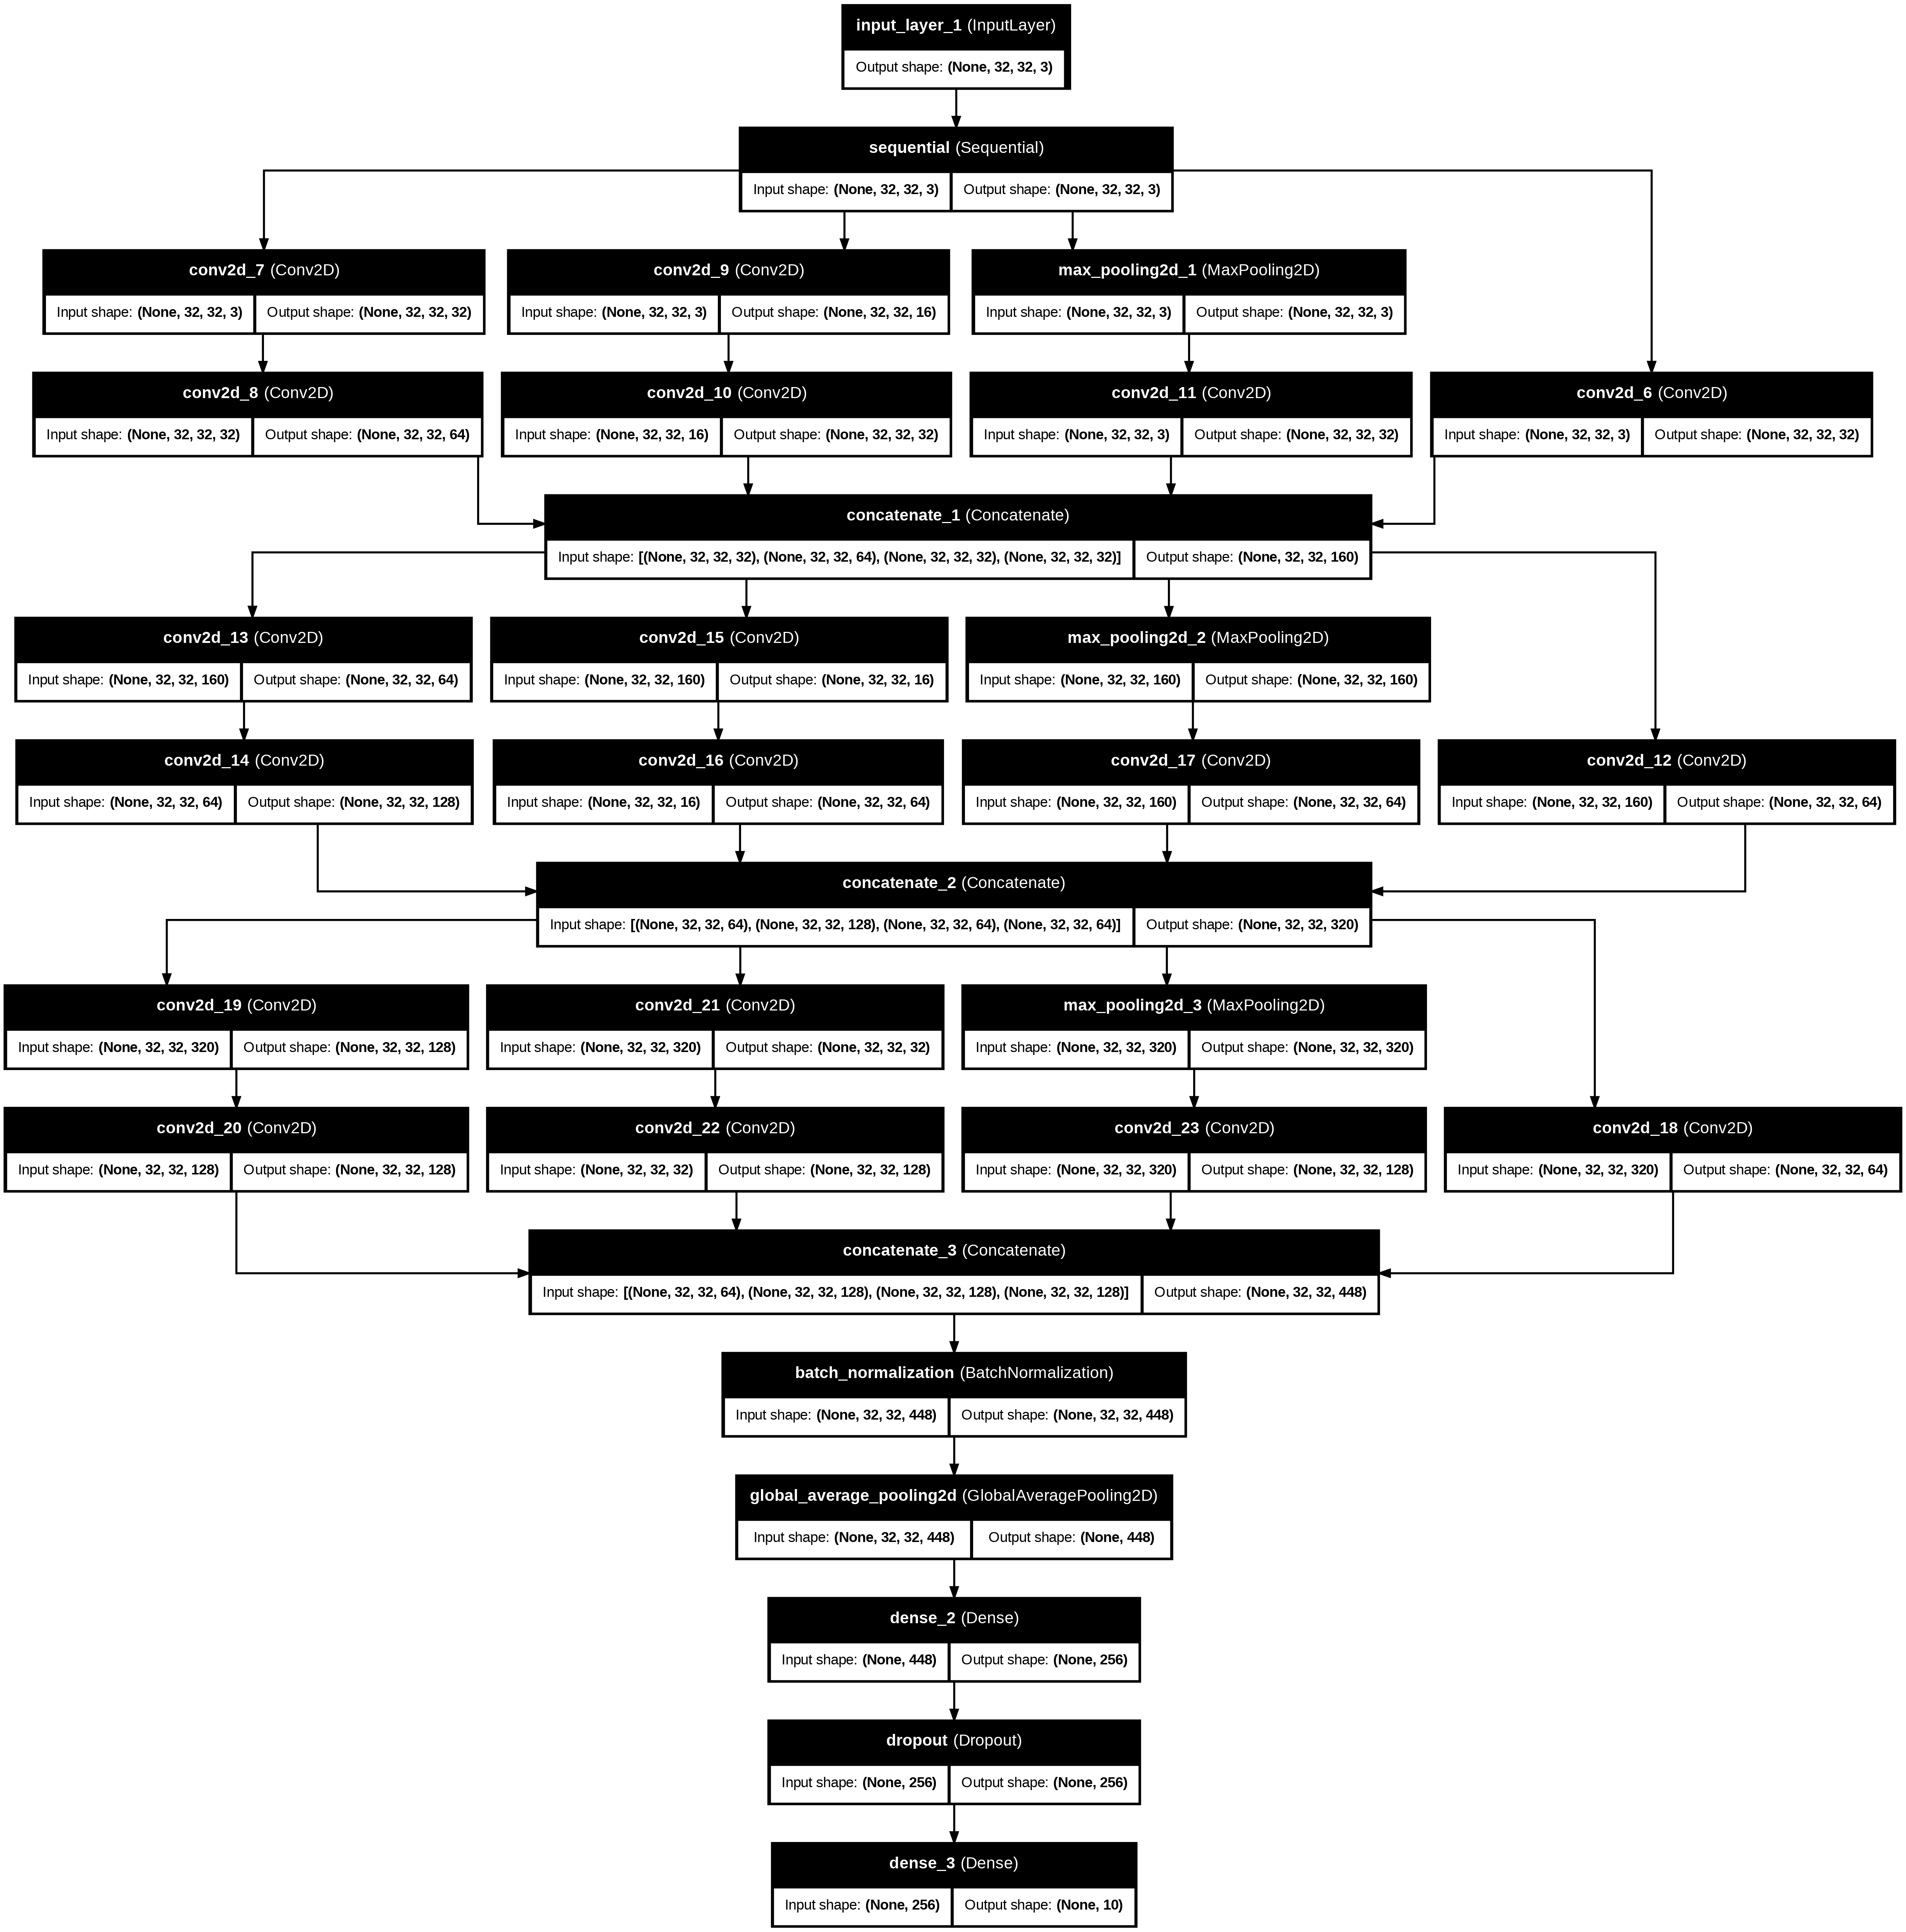

In [23]:
plot_model(model2, to_file='model_architectureM2.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_architectureM2.png'))

## Callbacks
Early stopping and learning rate

In [24]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

In [25]:
# Entrenar el modelo
history = model2.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.3308 - loss: 1.8040 - val_accuracy: 0.2578 - val_loss: 3.2254 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 137s 104ms/step - accuracy: 0.5029 - loss: 1.3735 - val_accuracy: 0.3802 - val_loss: 2.4352 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 103ms/step - accuracy: 0.5735 - loss: 1.1932 - val_accuracy: 0.4773 - val_loss: 1.6040 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.6159 - loss: 1.0767 - val_accuracy: 0.5980 - val_loss: 1.1647 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.6454 - loss: 0.9982 - val_accuracy: 0.6452 - val_loss: 1.0204 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 103ms/step - accuracy: 0.6690 - loss: 0.9264 - val_accuracy: 0.6133 - val_loss: 1.1588 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.

In [26]:
# Evaluar el modelo en el conjunto de pruebas
test_loss, test_acc = model2.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

313/313 - 5s - 16ms/step - accuracy: 0.7563 - loss: 0.7107
Test accuracy: 0.7563


In [27]:
# Hacer predicciones sobre algunas imágenes de prueba
num_images_to_display = 9
predictions = model.predict(x_test[:num_images_to_display])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


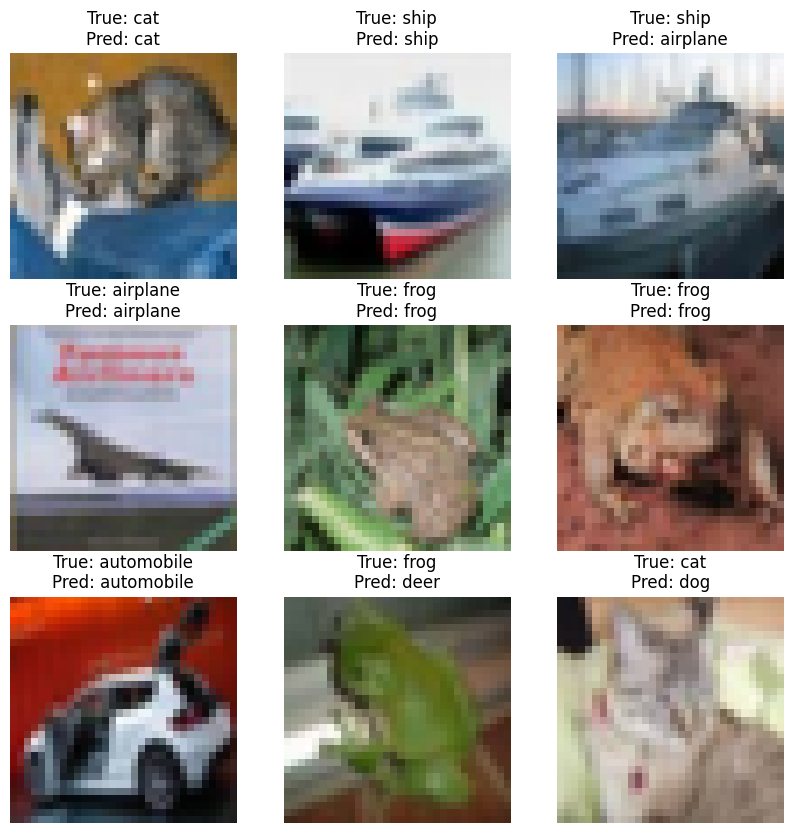

In [28]:
# Mostrar imágenes con predicciones
plot_images_with_predictions(x_test[:num_images_to_display], y_test[:num_images_to_display], predictions, class_names)